# Data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
catalog = pd.read_csv('data/data_catalogue.csv')
data = pd.read_csv('data/data_arena_members.csv')

In [3]:
def plot_hist2d(x,
                y,
                title,
                xlabel,
                ylabel,
                ax,
                bins=(50,50),
                cmap=plt.cm.BuPu):
    ax.hist2d(x, y, bins=bins, cmap=cmap)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
def price_ditributions(catalog,
                       price='creds'):
    if not price in ['creds', 'gold']:
        raise ValueError('Can display only creds and gold distibutions!')
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(16,30))
    for i, ax in enumerate(axs.flat):
        ax.set_title(f'Level {i + 1}')
        sns.distplot(catalog[catalog['item_level']==i+1]['item_price_credit' if price=='creds' else 'item_price_gold'].values,
                     kde=i!=0 and i!=9, bins=15, ax=ax)
    plt.show()
    
def get_regression_line(x,
                        y,
                        degree):
    params = np.polyfit(x, y, degree)
    poly = np.poly1d(params)
    x_grid = np.linspace(min(x), max(x), 100)
    y_grid = poly(x_grid)
    return x_grid, y_grid

# Cleaning catalog

In [4]:
removed_tanks = pd.DataFrame()

masks = [
    ('cleaning by crew_size: 2 <= crew_size <= 6', \
    (catalog['crew_size'] >= 2) & (catalog['crew_size'] <= 6)),
    
    ('cleaning by 1 level: item_price_credit = item_price_gold = 0', \
    (catalog['item_level'] != 1) | \
    ((catalog['item_price_credit'] == 0) & (catalog['item_price_gold'] == 0))),
    
    ('cleaning by price: item_price_credit > 100 or item_price_gold > 100', \
    (catalog['item_level'] == 1) | \
    (((catalog['item_price_credit'] > 100) & (catalog['item_price_gold'] == 0)) | \
    ((catalog['item_price_credit'] == 0) & (catalog['item_price_gold'] > 100)))),
    
    ('custom cleaning by price 2 level: 2000 < item_price_credit < 20000', \
    (catalog['item_level'] != 2) | (catalog['item_price_gold'] != 0) | \
    (catalog['item_price_credit'] > 2000) & (catalog['item_price_credit'] < 20000)),
    
    ('custom cleaning by price 5 level: item_price_credit < 500000', \
    (catalog['item_level'] != 5) | \
    (catalog['item_price_gold'] != 0) | (catalog['item_price_credit'] < 500000))
]

for mask in masks:
    N = len(catalog)
    
    removed_tanks = pd.concat([removed_tanks, catalog.loc[~mask[1]]])
    catalog = catalog.loc[mask[1]]

    print(f'[{mask[0].upper()}]: removed {N - len(catalog)} rows.')
    
catalog.index = np.arange(len(catalog))
removed_tanks.index = np.arange(len(removed_tanks))

print(f'\nTotally removed {len(removed_tanks)} rows.')

[CLEANING BY CREW_SIZE: 2 <= CREW_SIZE <= 6]: removed 7 rows.
[CLEANING BY 1 LEVEL: ITEM_PRICE_CREDIT = ITEM_PRICE_GOLD = 0]: removed 9 rows.
[CLEANING BY PRICE: ITEM_PRICE_CREDIT > 100 OR ITEM_PRICE_GOLD > 100]: removed 98 rows.
[CUSTOM CLEANING BY PRICE 2 LEVEL: 2000 < ITEM_PRICE_CREDIT < 20000]: removed 20 rows.
[CUSTOM CLEANING BY PRICE 5 LEVEL: ITEM_PRICE_CREDIT < 500000]: removed 1 rows.

Totally removed 135 rows.


In [5]:
removed_tanks

,item_cd,item_class,item_price_credit,item_price_gold,item_level,crew_size
0,46145,lightTank,0,0,10,1
1,46353,heavyTank,0,0,10,1
2,57857,mediumTank,0,1,1,1
3,59921,SPG,0,0,1,0
4,65025,lightTank,0,0,1,1
...,...,...,...,...,...,...
130,42753,mediumTank,915000,0,2,5
131,42769,lightTank,500,0,2,3
132,43009,lightTank,38500,0,2,3
133,43265,lightTank,39300,0,2,2


In [6]:
classEncoder = LabelEncoder()

catalog['item_class'] = classEncoder.fit_transform(catalog['item_class'])
catalog

,item_cd,item_class,item_price_credit,item_price_gold,item_level,crew_size
0,1,4,356700,0,5,4
1,17,4,373000,0,5,5
2,33,2,0,1500,5,5
3,49,4,0,7500,8,4
4,81,4,0,0,1,5
...,...,...,...,...,...,...
748,64817,3,0,3500,6,5
749,65041,1,0,0,1,6
750,65073,2,0,12250,8,4
751,65297,2,0,12500,8,5


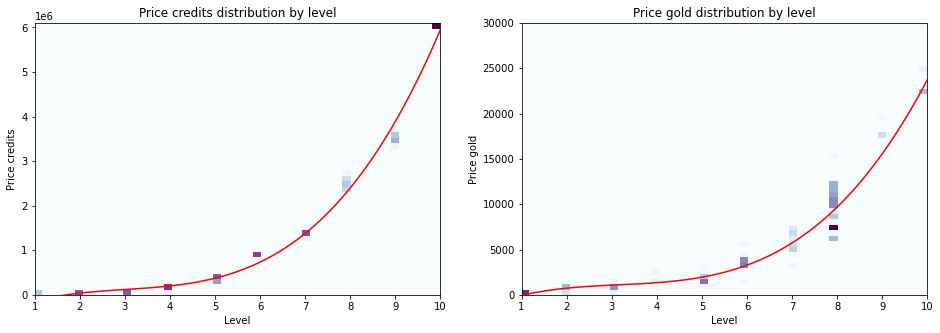

In [7]:
creds_catalog = catalog[catalog['item_price_gold'] == 0]
gold_catalog = catalog[catalog['item_price_credit'] == 0]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

degree = 3
prices = creds_catalog[['item_level', 'item_price_credit']].values

plot_hist2d(x=creds_catalog['item_level'],
            y=creds_catalog['item_price_credit'],
            title='Price credits distribution by level',
            xlabel='Level',
            ylabel='Price credits',
            ax=axs[0])
axs[0].plot(*get_regression_line(prices[:,0], prices[:,1], degree), '-r')

degree = 3
prices = gold_catalog[['item_level', 'item_price_gold']].values

plot_hist2d(x=gold_catalog['item_level'],
            y=gold_catalog['item_price_gold'],
            title='Price gold distribution by level',
            xlabel='Level',
            ylabel='Price gold',
            ax=axs[1])
axs[1].plot(*get_regression_line(prices[:,0], prices[:,1], degree), '-r')

plt.show()

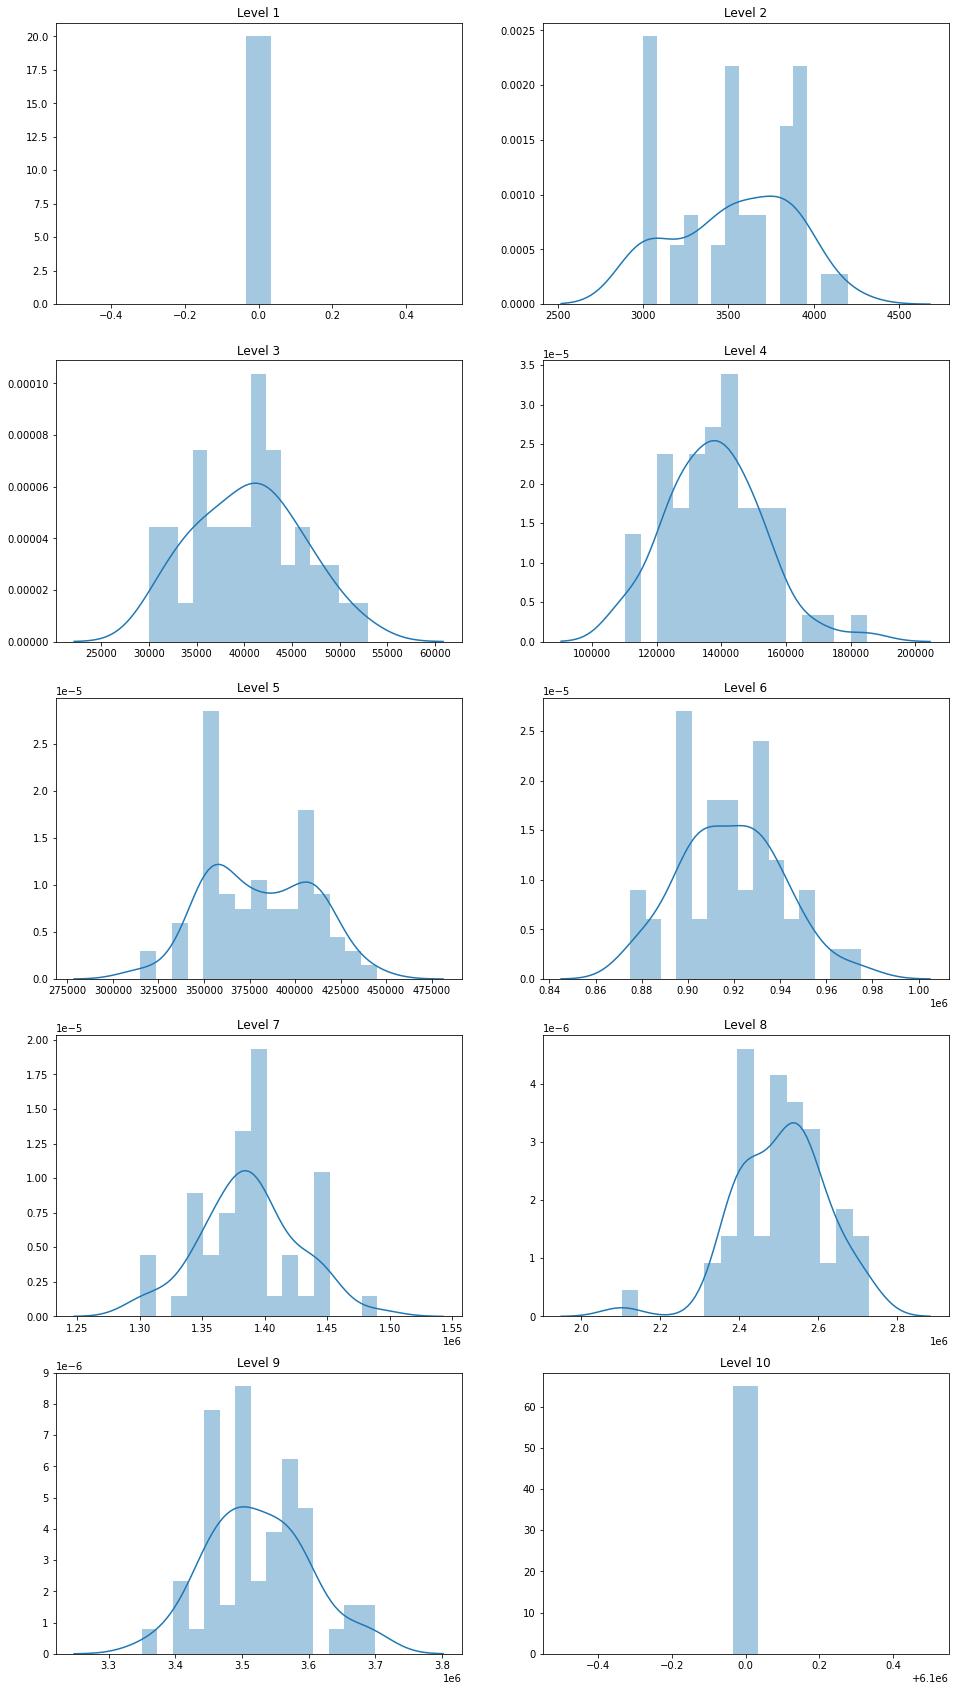

In [8]:
price_ditributions(creds_catalog, price='creds')

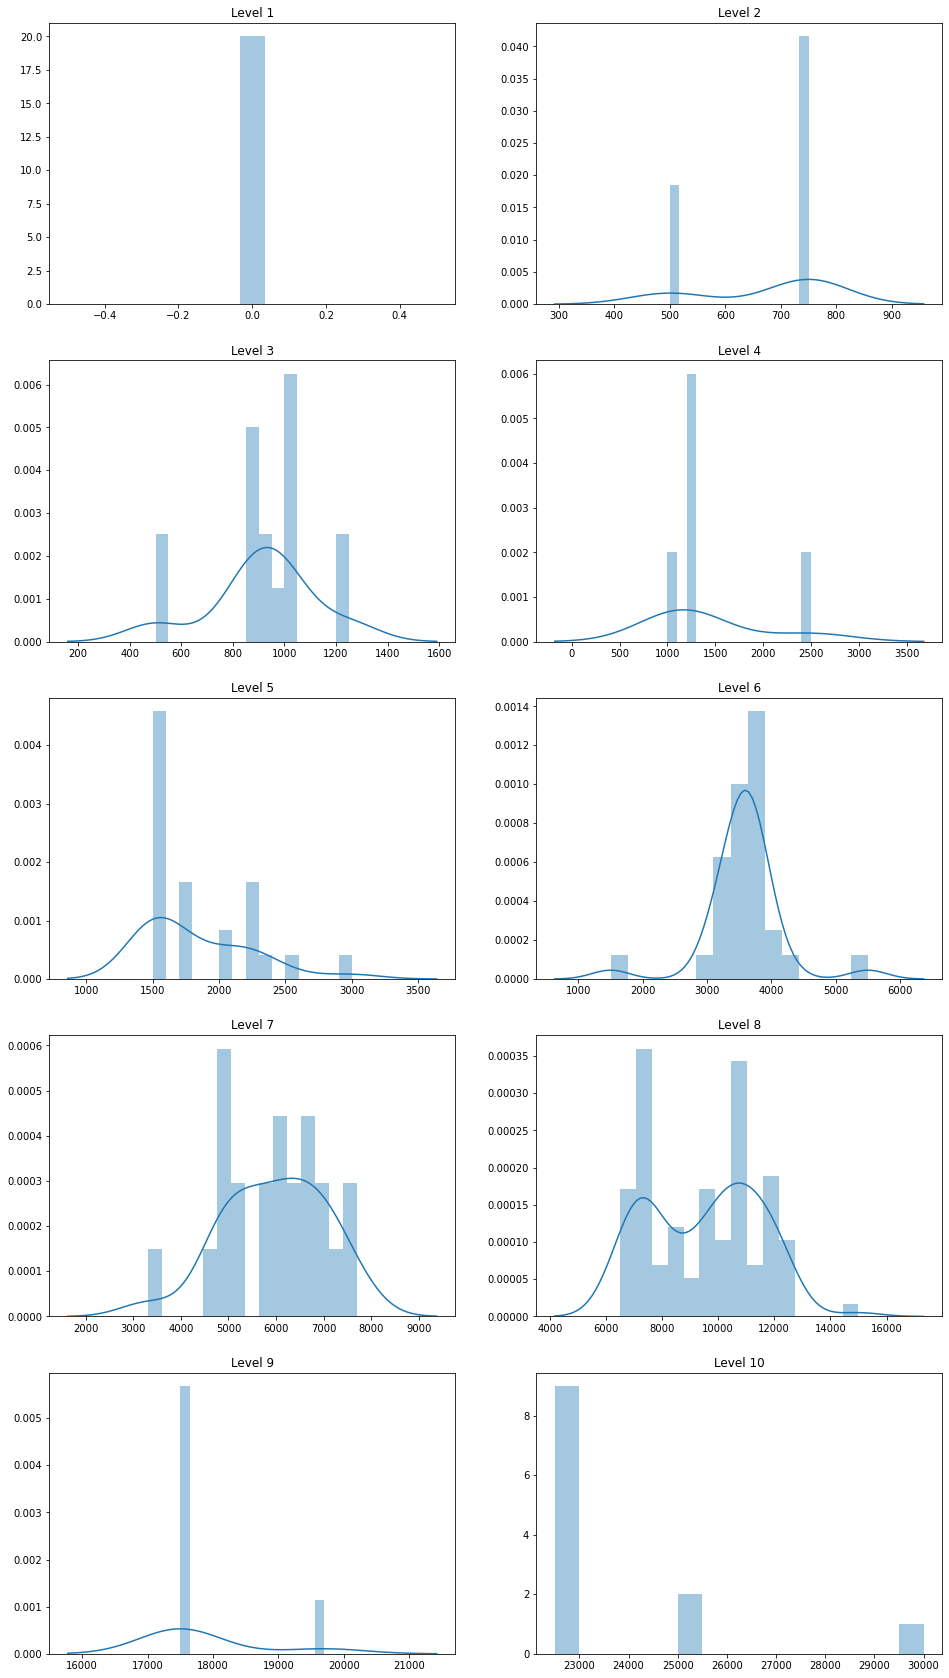

In [9]:
price_ditributions(gold_catalog, price='gold')

In [10]:
catalog.shape

(753, 6)

In [11]:
catalog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 753 entries, 0 to 752
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   item_cd            753 non-null    int64
 1   item_class         753 non-null    int32
 2   item_price_credit  753 non-null    int64
 3   item_price_gold    753 non-null    int64
 4   item_level         753 non-null    int64
 5   crew_size          753 non-null    int64
dtypes: int32(1), int64(5)
memory usage: 38.2 KB


In [12]:
catalog.describe()

,item_cd,item_class,item_price_credit,item_price_gold,item_level,crew_size
count,753.000000,753.000000,7.530000e+02,753.000000,753.000000,753.000000
mean,23770.243028,2.386454,1.168060e+06,2238.698539,6.175299,4.290837
std,22300.034277,1.459808,1.844741e+06,4594.101058,2.525103,0.964328
min,1.000000,0.000000,0.000000e+00,0.000000,1.000000,2.000000
25%,4993.000000,1.000000,0.000000e+00,0.000000,4.000000,4.000000
50%,14625.000000,3.000000,1.400000e+05,0.000000,6.000000,4.000000
75%,49937.000000,4.000000,1.400000e+06,1500.000000,8.000000,5.000000
max,65345.000000,4.000000,6.100000e+06,30000.000000,10.000000,6.000000


In [13]:
# --> no duplicates
catalog.duplicated().sum()

0

In [14]:
# --> no missing values
catalog.isnull().sum()

item_cd              0
item_class           0
item_price_credit    0
item_price_gold      0
item_level           0
crew_size            0
dtype: int64

#  Looking on removed tanks

In [15]:
s1 = set(removed_tanks['item_cd'])
s2 = set(data['vehicle_type_cd'])

removed_ids = s1.intersection(s2)

print(removed_ids)

{6225, 13889, 9297, 65281}


In [16]:
removed_tanks[removed_tanks['item_cd'] == 9297]

,item_cd,item_class,item_price_credit,item_price_gold,item_level,crew_size
18,9297,AT-SPG,0,5,10,5


In [17]:
data[data['vehicle_type_cd'] == 9297]

,dt,arena_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,shots,...,mileage_meter,remained_hp,original_credits,original_xp,premium_xp_factor,daily_xp_factor,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp
259,2018-10-27,4yNy1TNaa7yd71T4c,cdcyd44Ta,2,500019571,0,0,9297,365,5,...,1226,0,22046,384,15,10,34065,1270,0,0
3252,2018-10-17,424y7TyaNcyyT4cTy,cyNy71y2c,2,500135958,0,0,9297,415,5,...,1117,0,34650,622,15,10,41198,1400,0,201
3269,2018-10-17,424y7TyaNcyyT4cTy,c2yyN4a22,1,500040230,0,0,9297,477,9,...,1339,1330,104877,4430,15,20,22696,1140,34959,869
3498,2018-10-17,424y12T24Ny22TTTa,cyyT1T4cN,1,500159862,0,0,9297,656,8,...,2342,874,52922,1646,15,10,51289,0,0,0
3653,2018-10-17,424y7yd21cddc7cdd,c2yTNddca,2,500069934,0,0,9297,323,3,...,1267,2000,18123,1488,15,20,38614,390,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377598,2018-10-17,21cN2N1TydaT1dc27,cdyc7TddN,1,500012667,0,0,9297,356,6,...,1181,1237,38034,2189,15,20,66027,390,0,0
1383488,2018-10-17,24Ndc74a7NcyTTTNN,ca2adcNd2,2,500004709,0,0,9297,281,3,...,528,0,25070,412,15,10,33198,240,8357,0
1386077,2018-10-26,12ac27ycN147ad7,cdaa1TTdy,2,0,0,0,9297,433,1,...,1512,370,11817,2368,15,40,45529,400,0,469
1394142,2018-10-17,a2adaNdTcTTNd1Naa,cdacaT4Tc,2,500156864,0,0,9297,290,4,...,797,1713,24936,891,15,10,29711,0,0,0


# Visualizing catalog

In [18]:
for feature in ['item_cd']:
    catalog[feature] = pd.Categorical(catalog[feature])

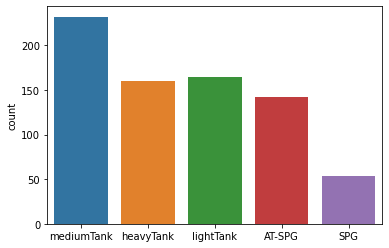

In [19]:
sns.countplot(classEncoder.inverse_transform(catalog['item_class']));

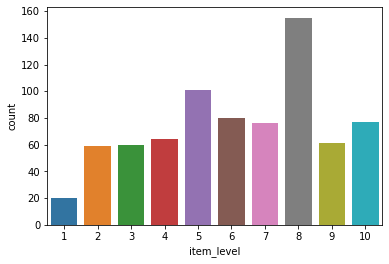

In [20]:
sns.countplot(catalog['item_level']);

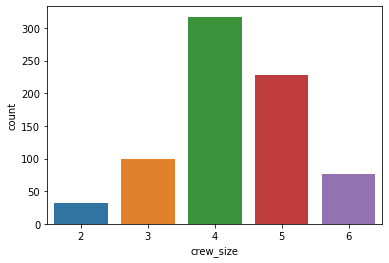

In [21]:
sns.countplot(catalog['crew_size']);

# Cleaning data

In [22]:
data.head()

,dt,arena_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,shots,...,mileage_meter,remained_hp,original_credits,original_xp,premium_xp_factor,daily_xp_factor,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp
0,2018-10-27,4yNy14y4yN12d42dT,c42c4aydT,2,0,0,0,2849,132,3,...,459,-3,27279,1084,15,20,11956,0,0,0
1,2018-10-27,4yNy14y4yN12d42dT,c2TaaayN4,1,500033550,0,0,63553,195,6,...,708,0,6282,68,15,10,9832,0,0,0
2,2018-10-27,4yNy14y4yN12d42dT,cyyd47dc4,2,500051107,67896661,0,17665,224,11,...,656,0,36102,3560,15,20,39190,0,0,1130
3,2018-10-27,4yNy14y4yN12d42dT,c2cdc441y,2,0,0,0,11537,381,8,...,1912,387,16317,1678,15,20,7217,0,0,0
4,2018-10-27,4yNy14y4yN12d42dT,cdT7cTT21,1,0,0,0,7937,198,5,...,507,0,11620,232,15,10,9532,0,0,0


In [23]:
mask = ~data['vehicle_type_cd'].isin(removed_ids)

removed_data = data.loc[~mask]
data = data.loc[mask]

data.reset_index()
removed_data.reset_index();

In [24]:
# --> no duplicates
data.duplicated().sum()

0

In [25]:
#  --> no null values
data.isnull().sum()

dt                          0
arena_id                    0
account_db_id               0
team_id                     0
clan_db_id                  0
prebattle_id                0
is_prebattle_creator        0
vehicle_type_cd             0
life_time_sec               0
shots                       0
hits                        0
he_hits                     0
pierced                     0
damage_dealt                0
damage_assisted_radio       0
damage_assisted_stun        0
damage_assisted_track       0
damage_received             0
shots_received              0
no_damage_shots_received    0
pierced_received            0
spotted                     0
damaged                     0
kills_made                  0
mileage_meter               0
remained_hp                 0
original_credits            0
original_xp                 0
premium_xp_factor           0
daily_xp_factor             0
battle_num                  0
damage_blocked_by_armor     0
booster_bonus_credits       0
booster_bo

In [26]:
data.describe()

,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,shots,hits,he_hits,pierced,...,mileage_meter,remained_hp,original_credits,original_xp,premium_xp_factor,daily_xp_factor,battle_num,damage_blocked_by_armor,booster_bonus_credits,booster_bonus_xp
count,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06,...,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06
mean,1.500015e+00,2.843357e+08,7.294752e+06,7.079043e-02,2.386333e+04,2.976125e+02,7.738088e+00,5.339142e+00,3.320121e-01,3.643013e+00,...,1.172246e+03,1.897758e+02,3.101764e+04,1.051120e+03,1.499911e+01,1.358995e+01,2.330440e+04,4.412997e+02,2.002091e+03,1.087956e+02
std,5.000002e-01,2.476789e+08,2.682752e+07,2.564745e-01,2.240353e+04,1.348247e+02,5.083874e+00,4.033766e+00,1.314188e+00,3.004952e+00,...,7.146780e+02,3.943647e+02,2.388215e+04,1.048548e+03,1.153706e-01,7.431287e+00,1.681411e+04,7.220207e+02,7.046242e+03,2.797172e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.900000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-1.300000e+01,-1.037000e+03,0.000000e+00,0.000000e+00,0.000000e+00,2.501000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.377000e+03,2.010000e+02,4.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,...,6.920000e+02,0.000000e+00,1.472100e+04,3.300000e+02,1.500000e+01,1.000000e+01,1.052100e+04,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,5.000197e+08,0.000000e+00,0.000000e+00,1.334500e+04,2.870000e+02,7.000000e+00,5.000000e+00,0.000000e+00,3.000000e+00,...,1.027000e+03,0.000000e+00,2.421600e+04,6.900000e+02,1.500000e+01,1.000000e+01,1.931200e+04,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000e+00,5.000720e+08,0.000000e+00,0.000000e+00,5.019300e+04,3.740000e+02,1.000000e+01,7.000000e+00,0.000000e+00,5.000000e+00,...,1.507000e+03,1.180000e+02,3.972800e+04,1.418000e+03,1.500000e+01,2.000000e+01,3.192300e+04,6.400000e+02,0.000000e+00,0.000000e+00
max,2.000000e+00,5.001649e+08,2.687535e+08,1.000000e+00,6.507300e+04,9.000000e+02,6.300000e+01,5.100000e+01,2.700000e+01,4.000000e+01,...,1.491800e+04,3.000000e+03,3.055860e+05,1.341000e+04,1.500000e+01,4.000000e+01,2.210440e+05,1.665000e+04,1.577200e+05,3.274000e+03


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1402958 entries, 0 to 1403404
Data columns (total 34 columns):
 #   Column                    Non-Null Count    Dtype 
---  ------                    --------------    ----- 
 0   dt                        1402958 non-null  object
 1   arena_id                  1402958 non-null  object
 2   account_db_id             1402958 non-null  object
 3   team_id                   1402958 non-null  int64 
 4   clan_db_id                1402958 non-null  int64 
 5   prebattle_id              1402958 non-null  int64 
 6   is_prebattle_creator      1402958 non-null  int64 
 7   vehicle_type_cd           1402958 non-null  int64 
 8   life_time_sec             1402958 non-null  int64 
 9   shots                     1402958 non-null  int64 
 10  hits                      1402958 non-null  int64 
 11  he_hits                   1402958 non-null  int64 
 12  pierced                   1402958 non-null  int64 
 13  damage_dealt              1402958 non-null

# Visualizing data

In [28]:
for feature in ['arena_id', 'account_db_id', 'team_id', 'clan_db_id', 
               'prebattle_id', 'is_prebattle_creator', 'vehicle_type_cd']:
    data[feature] = pd.Categorical(data[feature])
    
data['dt'] = pd.to_datetime(data['dt'])

## dt

All battles took place in October 2018 (between October 1 and October 31)

In [29]:
data['dt'].describe()

count                 1402958
unique                     31
top       2018-10-10 00:00:00
freq                    90939
first     2018-10-01 00:00:00
last      2018-10-31 00:00:00
Name: dt, dtype: object

## arena_id

47.363 unique battles were held.

There were 30 players in most battles (30 -> 20 -> 14). 
However, in some battles, a number of players was either odd (19, 13) or 
strangely small (2, 4). Are those battles connected to special events?

In [30]:
battles = data['arena_id'].value_counts()
battles

yyyyd1d41y77yN4      30
4TNN1T2TdT12d7y7a    30
4TNN1T1TyN77TNadc    30
4TNN1Nya1ayd274N2    30
4TNN1Ny1y2cNTcTaN    30
                     ..
424y1a22T2d7T11a7     4
71a1daddT4yN4c7       4
Ty7cc77dTNNd7N4       3
Ty72acc1444a4d1       3
4d2721ay1a7c11Nya     2
Name: arena_id, Length: 47363, dtype: int64

In [31]:
battles.to_frame()['arena_id'].value_counts()

30    45479
20     1033
14      417
29      373
28       26
19        8
27        5
13        5
12        4
18        3
3         2
4         2
6         1
17        1
7         1
21        1
24        1
2         1
Name: arena_id, dtype: int64

## account_db_id

367.746 unique players took part in battles.

In [32]:
data['account_db_id'].value_counts()

c2aTcT4y4    214
cdNcaNN77    201
c277NNN2y    140
cadaaNc77    121
c4NacTcc4     98
            ... 
cdN1a12cT      1
cdN1Ty4y2      1
cdN1Ty212      1
cdN1Tdc1y      1
c2111224a      1
Name: account_db_id, Length: 367685, dtype: int64

## team_id

Either 1 or 2

In [33]:
data['team_id'].value_counts()

2    701500
1    701458
Name: team_id, dtype: int64

## prebattle_id, is_prebattle_creator

~83% of players were not a part of any platoon

In [34]:
data[data['prebattle_id'] == 0].shape[0] / data.shape[0]

0.8267403585852178

In [35]:
data['is_prebattle_creator'].value_counts()

0    1303642
1      99316
Name: is_prebattle_creator, dtype: int64

## vehicle_type_cd

All tanks used in the battles are real (there is a corresponding entry in "catalog")

In [36]:
data['vehicle_type_cd'].describe()

count     1402958
unique        347
top         50193
freq        77041
Name: vehicle_type_cd, dtype: int64

In [37]:
data['vehicle_type_cd'].unique().isin(catalog['item_cd']).sum()

347

## Different battle characteristics

Need to be normalized to lifetime in a battle / mileage meter

In [38]:
target_params = ['shots', 'hits', 'he_hits', 'pierced']
damage_params = ['damage_dealt', 'damage_assisted_track', 'damage_assisted_radio', 
               'damage_assisted_stun']
income_params = ['damage_received', 'shots_received', 'no_damage_shots_received',
                'pierced_received']

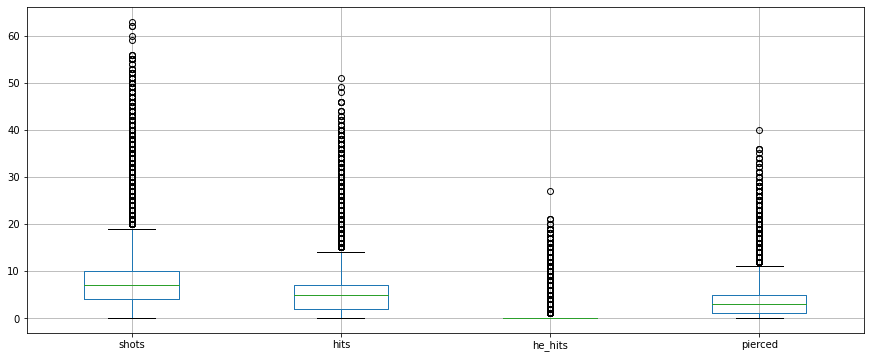

In [39]:
data[target_params].boxplot(figsize=(15, 6));

In [40]:
data[target_params].corr()

,shots,hits,he_hits,pierced
shots,1.000000,0.889603,0.042677,0.793255
hits,0.889603,1.000000,-0.164152,0.882728
he_hits,0.042677,-0.164152,1.000000,-0.090797
pierced,0.793255,0.882728,-0.090797,1.000000


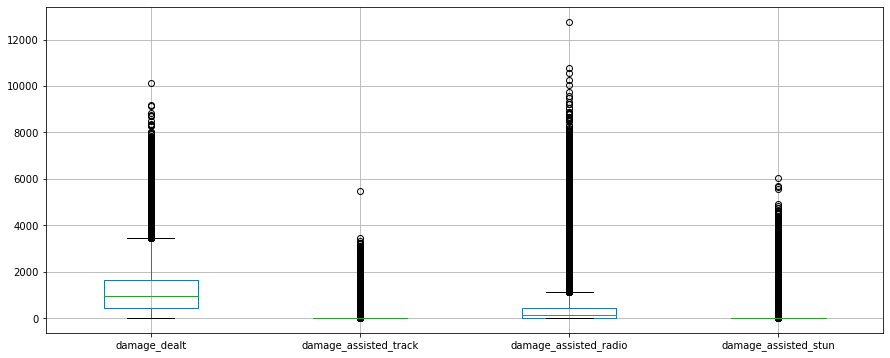

In [41]:
data[damage_params].boxplot(figsize=(15, 6));

In [42]:
data[damage_params].corr()

,damage_dealt,damage_assisted_track,damage_assisted_radio,damage_assisted_stun
damage_dealt,1.000000,0.162962,0.083276,0.052412
damage_assisted_track,0.162962,1.000000,0.032367,-0.020921
damage_assisted_radio,0.083276,0.032367,1.000000,-0.112713
damage_assisted_stun,0.052412,-0.020921,-0.112713,1.000000


In [43]:
data[income_params].describe()

,damage_received,shots_received,no_damage_shots_received,pierced_received
count,1.402958e+06,1.402958e+06,1.402958e+06,1.402958e+06
mean,1.162548e+03,5.298307e+00,1.668547e+00,3.629759e+00
std,5.268389e+02,3.593638e+00,2.452998e+00,1.881117e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.000000e+02,3.000000e+00,0.000000e+00,2.000000e+00
50%,1.300000e+03,5.000000e+00,1.000000e+00,4.000000e+00
75%,1.500000e+03,7.000000e+00,2.000000e+00,5.000000e+00
max,3.000000e+03,6.700000e+01,6.200000e+01,2.000000e+01


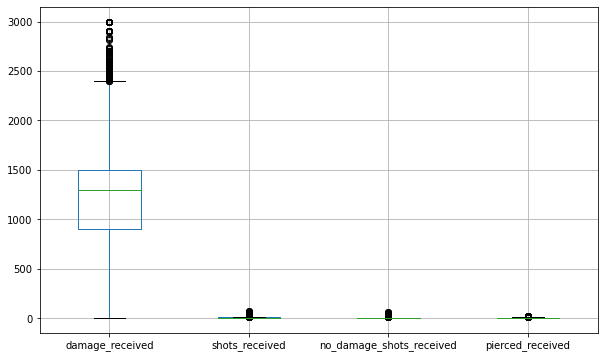

In [44]:
data[income_params].boxplot(figsize=(10, 6));

## life_time_sec

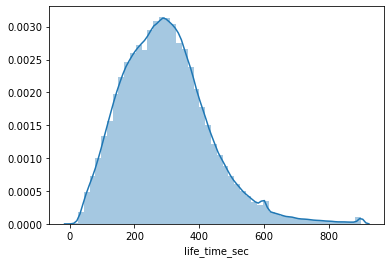

In [45]:
sns.distplot(data['life_time_sec']);

# Create new features (normalized to time/etc) 

In [46]:
def normalize_feature(target_feature, norm_feature):
    if norm_feature != 0:
        return target_feature / norm_feature
    else:
        return 0
    
normalize_feature = np.vectorize(normalize_feature)

## Normalize to time

In [47]:
target_features = ['shots', 'hits', 'he_hits', 'pierced', 'damage_dealt', 
                   'damage_assisted_track', 'damage_assisted_radio', 
                   'damage_assisted_stun', 'damage_received', 'shots_received', 
                   'no_damage_shots_received', 'pierced_received', 'spotted', 
                   'damaged', 'kills_made', 'mileage_meter']
# target_features = ['shots']

for feature in target_features:
    new_feature = feature + '_per_sec'
    data[new_feature] = normalize_feature(data[feature], data['life_time_sec'])

## Compare distributions before and after normalization

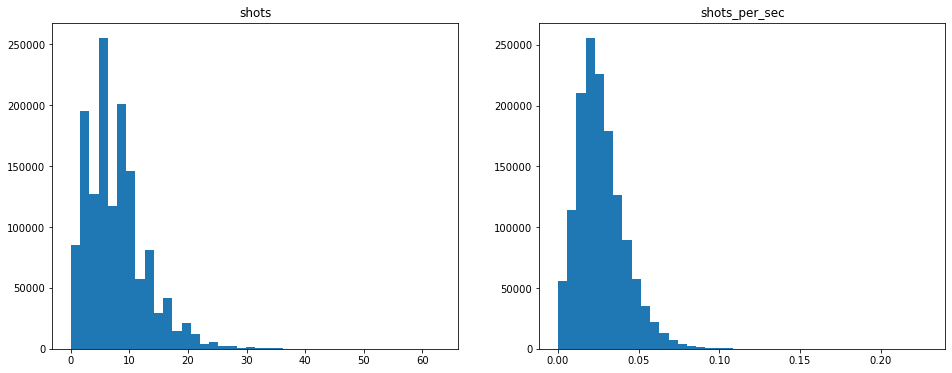

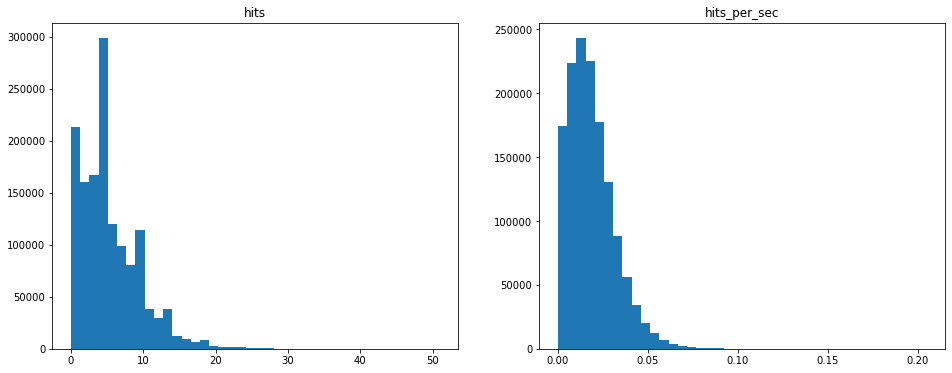

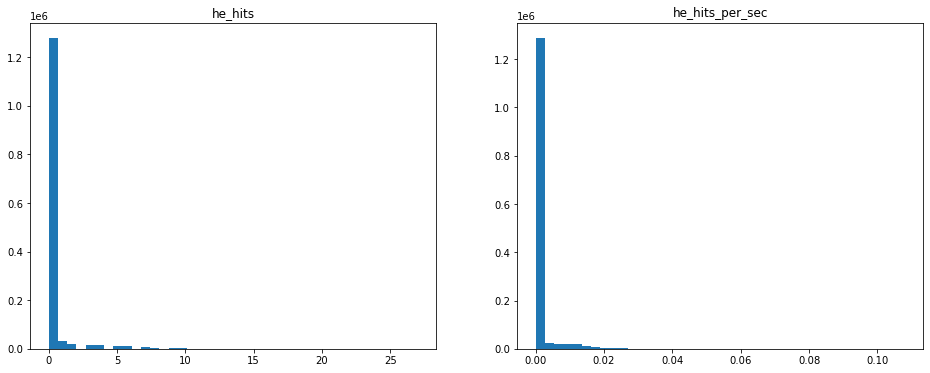

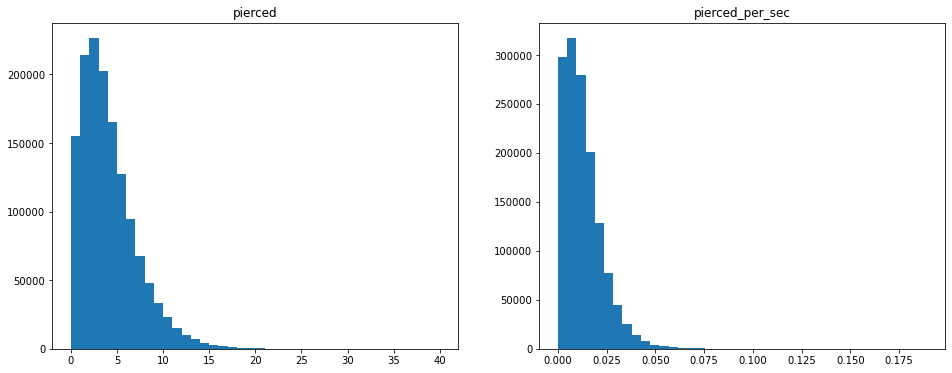

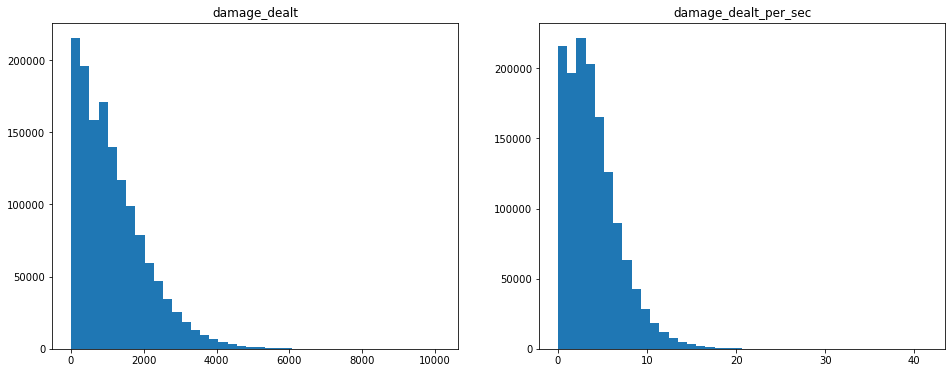

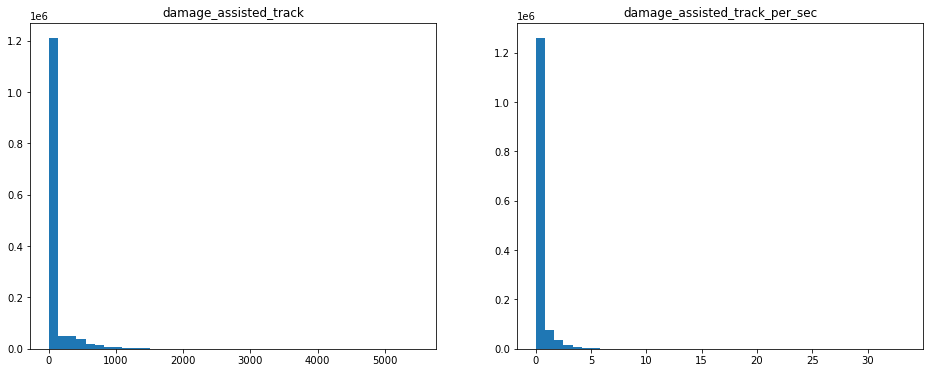

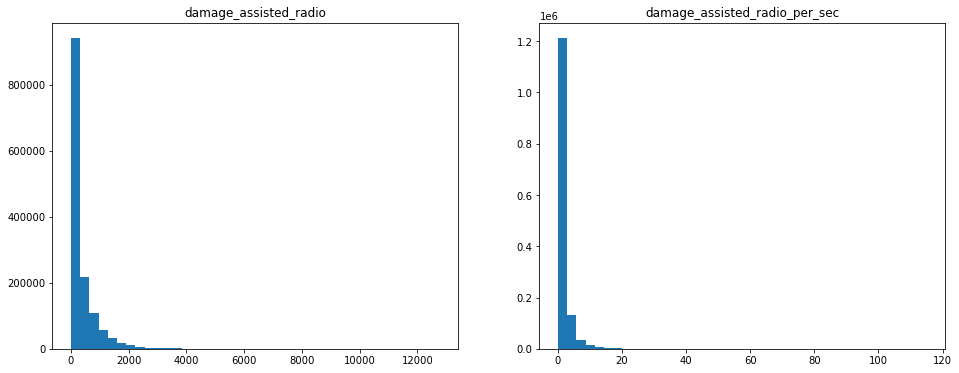

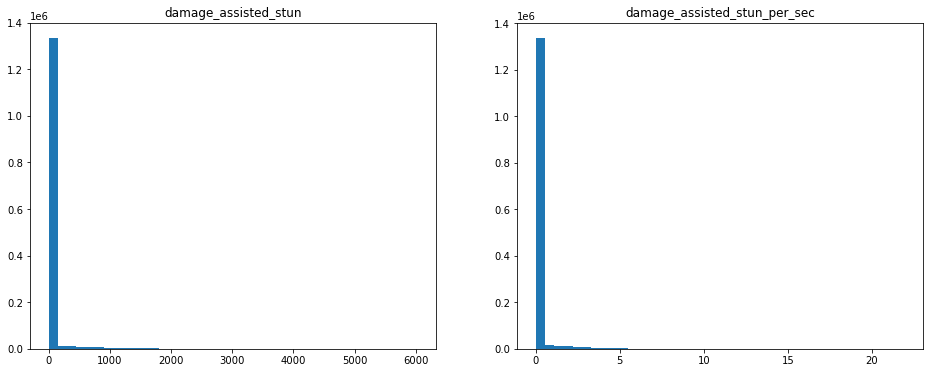

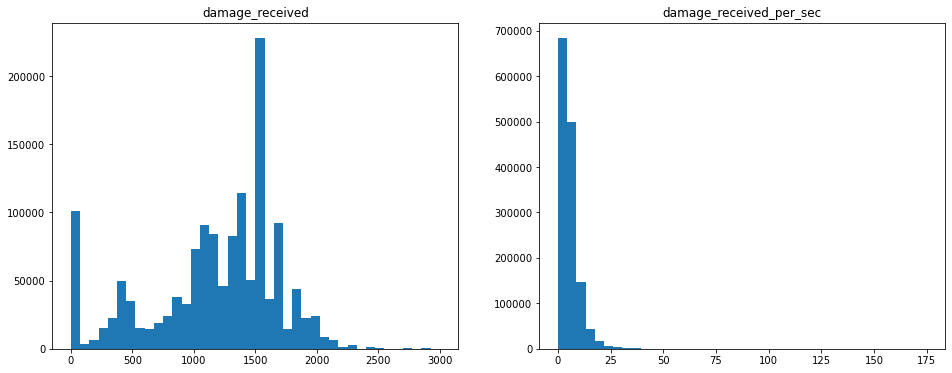

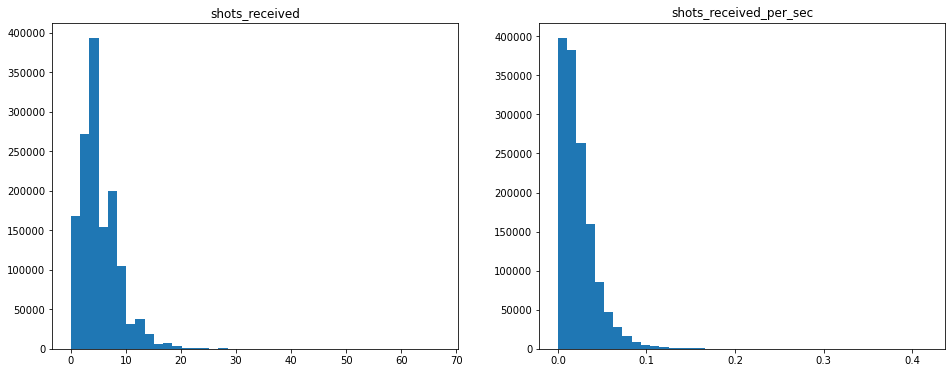

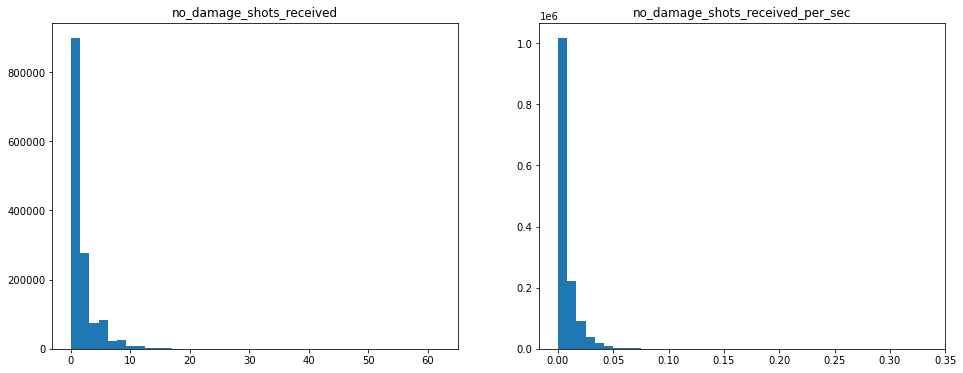

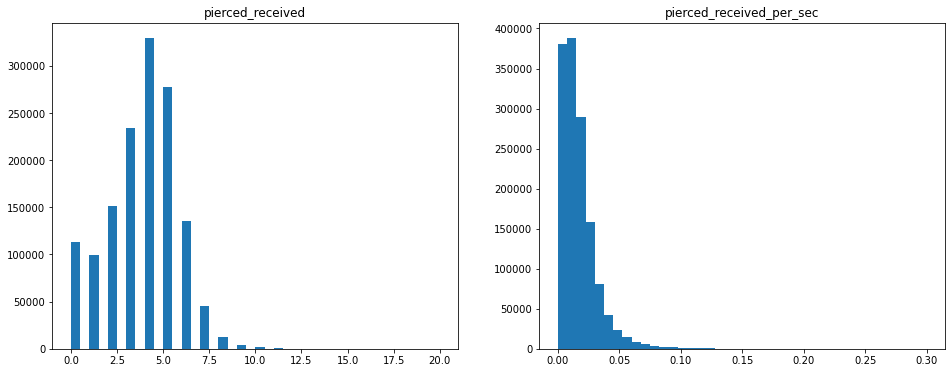

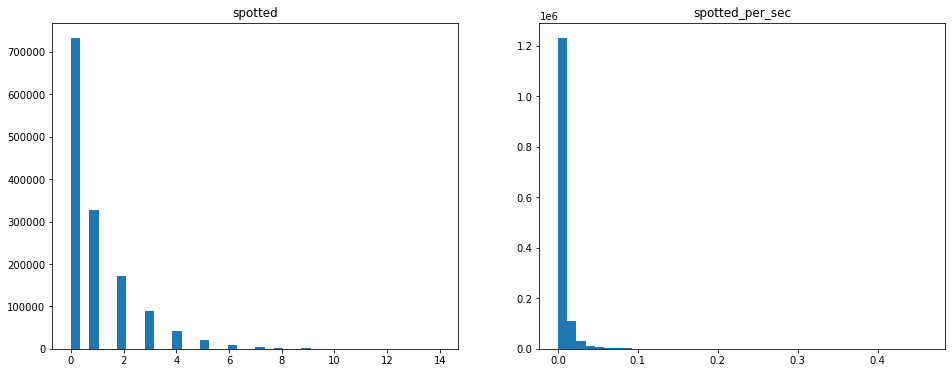

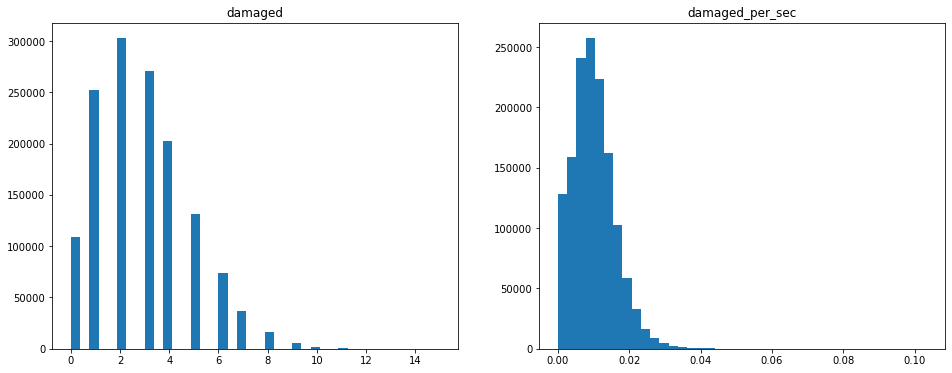

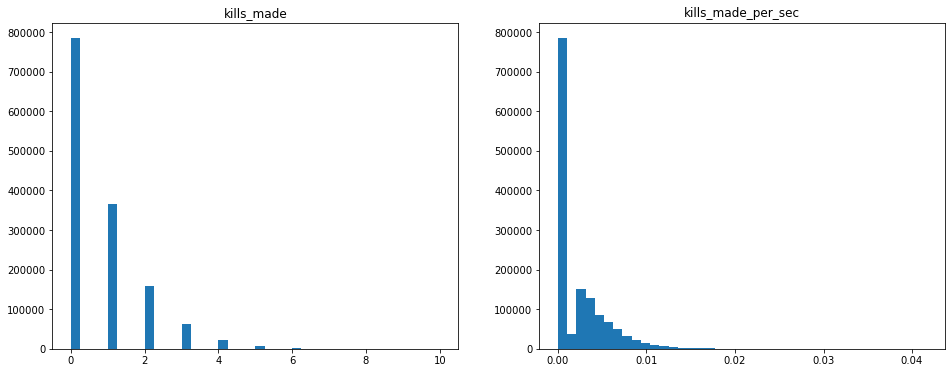

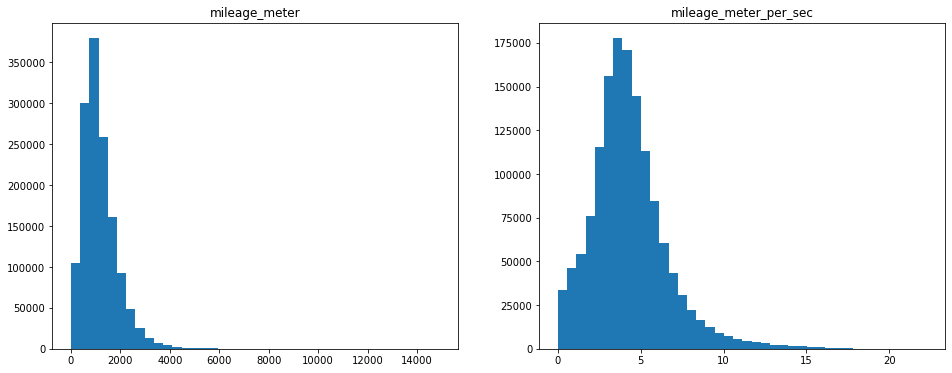

In [48]:
for feature in target_features:
    new_feature = feature + '_per_sec'

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    axes[0].hist(data[feature], bins=40)
    axes[1].hist(data[new_feature], bins=40)
    
    axes[0].set_title(feature)
    axes[1].set_title(new_feature)

# Joining data

In [49]:
joined_data = data.merge(catalog, how='left', left_on='vehicle_type_cd', right_on='item_cd')
joined_data

,dt,arena_id,account_db_id,team_id,clan_db_id,prebattle_id,is_prebattle_creator,vehicle_type_cd,life_time_sec,shots,...,spotted_per_sec,damaged_per_sec,kills_made_per_sec,mileage_meter_per_sec,item_cd,item_class,item_price_credit,item_price_gold,item_level,crew_size
0,2018-10-27,4yNy14y4yN12d42dT,c42c4aydT,2,0,0,0,2849,132,3,...,0.007576,0.015152,0.000000,3.477273,2849,2,0,12000,8,6
1,2018-10-27,4yNy14y4yN12d42dT,c2TaaayN4,1,500033550,0,0,63553,195,6,...,0.005128,0.005128,0.000000,3.630769,63553,4,0,7450,8,4
2,2018-10-27,4yNy14y4yN12d42dT,cyyd47dc4,2,500051107,67896661,0,17665,224,11,...,0.000000,0.017857,0.008929,2.928571,17665,4,3450000,0,9,4
3,2018-10-27,4yNy14y4yN12d42dT,c2cdc441y,2,0,0,0,11537,381,8,...,0.002625,0.010499,0.010499,5.018373,11537,0,2570000,0,8,5
4,2018-10-27,4yNy14y4yN12d42dT,cdT7cTT21,1,0,0,0,7937,198,5,...,0.005051,0.010101,0.005051,2.560606,7937,4,3450000,0,9,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1402953,2018-10-11,1ccdcTcya4T7Nyc,cac4aa12N,2,500150344,5640480,0,1921,364,9,...,0.000000,0.005495,0.000000,5.936813,1921,2,2540000,0,8,3
1402954,2018-10-11,1ccdcTcya4T7Nyc,cdTcc72Nc,1,500138824,5288203,0,913,311,6,...,0.003215,0.009646,0.003215,3.620579,913,2,0,10700,8,4
1402955,2018-10-11,1ccdcTcya4T7Nyc,cd42c2TTT,1,500154303,5288203,0,50193,174,2,...,0.005747,0.005747,0.000000,2.787356,50193,0,0,10900,8,4
1402956,2018-10-11,1ccdcTcya4T7Nyc,cd4a7Tc72,2,500156478,5640480,0,51361,136,7,...,0.014706,0.029412,0.000000,5.588235,51361,4,0,11000,8,4


In [50]:
joined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1402958 entries, 0 to 1402957
Data columns (total 56 columns):
 #   Column                            Non-Null Count    Dtype         
---  ------                            --------------    -----         
 0   dt                                1402958 non-null  datetime64[ns]
 1   arena_id                          1402958 non-null  category      
 2   account_db_id                     1402958 non-null  category      
 3   team_id                           1402958 non-null  category      
 4   clan_db_id                        1402958 non-null  category      
 5   prebattle_id                      1402958 non-null  category      
 6   is_prebattle_creator              1402958 non-null  category      
 7   vehicle_type_cd                   1402958 non-null  int64         
 8   life_time_sec                     1402958 non-null  int64         
 9   shots                             1402958 non-null  int64         
 10  hits              

In [51]:
joined_data.drop(['item_cd'], axis=1, inplace=True)

# Correlations

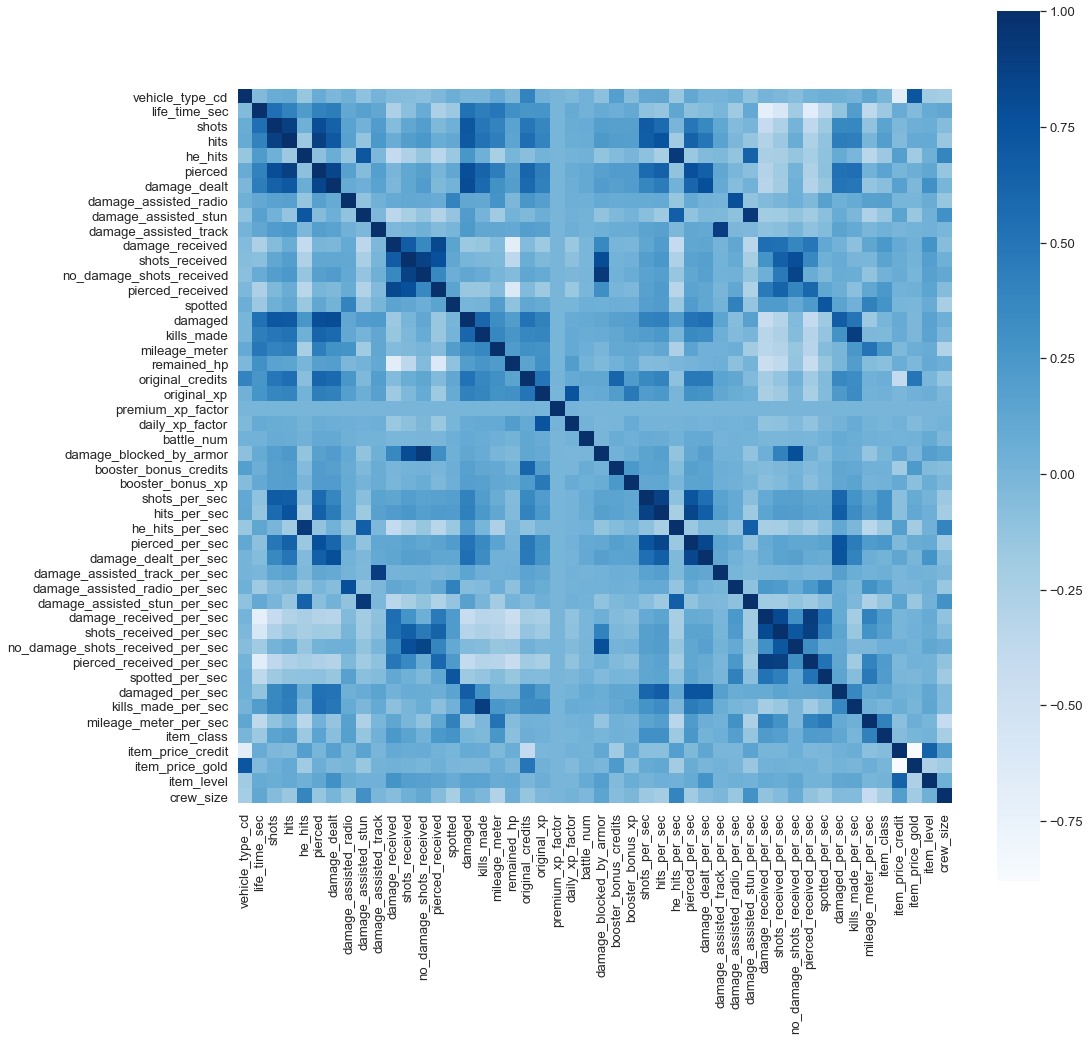

item_price_credit                  -0.879595
item_level                         -0.257673
he_hits_per_sec                    -0.197115
he_hits                            -0.191737
crew_size                          -0.190591
damage_assisted_stun               -0.150168
damage_assisted_stun_per_sec       -0.147580
booster_bonus_xp                   -0.081813
life_time_sec                      -0.039822
daily_xp_factor                    -0.037196
damage_dealt                       -0.025258
remained_hp                        -0.023619
damaged                            -0.017034
spotted_per_sec                    -0.015759
kills_made                         -0.015171
spotted                            -0.012602
damage_blocked_by_armor            -0.011887
kills_made_per_sec                 -0.003752
damage_assisted_radio_per_sec      -0.002405
premium_xp_factor                  -0.000887
damage_dealt_per_sec                0.000718
damage_assisted_radio               0.002846
no_damage_

In [52]:
sns.set(font_scale=1.2)

corr = joined_data.corr()

plt.figure(figsize=(16,16))
sns.heatmap(corr, square=True, cmap='Blues')

plt.show()

corr['item_price_gold'].sort_values()

# Regression model

In [53]:
res_data = joined_data.groupby('vehicle_type_cd').mean().reset_index()

features = ['item_level', 'item_class', 'damage_dealt', 'original_xp', 'original_credits', 'kills_made', 'damage_assisted_stun', 'he_hits', 'crew_size', 'hits', 'booster_bonus_credits']
target_credit = ['item_price_credit']
target_gold = ['item_price_gold']

credit_dataset = res_data[res_data['item_price_credit'] != 0][features + target_credit]
gold_dataset = res_data[res_data['item_price_gold'] != 0][features + target_gold]

gold_dataset

,item_level,item_class,damage_dealt,original_xp,original_credits,kills_made,damage_assisted_stun,he_hits,crew_size,hits,booster_bonus_credits,item_price_gold
0,8.0,4,1063.747118,1240.120084,51652.362954,0.683618,0.0,0.007707,4.0,6.970489,5386.457480,7500.0
1,6.0,4,416.653846,948.333333,20239.653846,0.371795,0.0,0.025641,5.0,5.538462,1028.179487,3650.0
3,7.0,3,637.062049,1177.643579,33906.291486,0.567100,0.0,0.005772,4.0,5.418470,2372.953824,4800.0
7,8.0,2,1047.282024,1161.835522,45384.159742,0.618945,0.0,0.090850,4.0,5.421744,4235.857696,12250.0
8,8.0,2,1230.972621,1282.980080,50404.405130,0.715299,0.0,0.027015,4.0,5.101055,4402.425505,10700.0
...,...,...,...,...,...,...,...,...,...,...,...,...
342,8.0,4,778.874320,1078.939064,37692.684440,0.497824,0.0,0.009793,4.0,5.212187,2717.435800,8700.0
343,8.0,2,992.139367,1192.404322,45097.992327,0.570467,0.0,0.066082,4.0,5.311463,3581.759161,10500.0
344,6.0,2,740.380000,1117.920000,27219.380000,0.660000,0.0,0.240000,6.0,2.140000,2823.220000,4200.0
345,6.0,3,434.962656,946.461964,26858.984786,0.432918,0.0,0.005533,5.0,5.576763,1420.182573,3500.0


In [54]:
credit_scaler = StandardScaler()
gold_scaler = StandardScaler()

normed_credit_dataset = pd.DataFrame(credit_scaler.fit_transform(credit_dataset), columns=[features + target_credit])
normed_gold_dataset = pd.DataFrame(gold_scaler.fit_transform(gold_dataset), columns=[features + target_gold])
#scaler.mean_
normed_gold_dataset

,item_level,item_class,damage_dealt,original_xp,original_credits,kills_made,damage_assisted_stun,he_hits,crew_size,hits,booster_bonus_credits,item_price_gold
0,0.385922,0.999792,0.069122,0.553343,1.143434,-0.044766,0.0,-0.306436,-0.548821,0.428188,1.616374,-0.282398
1,-1.598822,0.999792,-1.028147,-0.854382,-1.505697,-0.943119,0.0,0.333075,0.768350,-0.248084,-0.976360,-1.107332
2,-0.606450,0.303163,-0.654403,0.251925,-0.353147,-0.380451,0.0,-0.375437,-0.548821,-0.304749,-0.176356,-0.860923
3,0.385922,-0.393467,0.041202,0.175659,0.614817,-0.231086,0.0,2.658384,-0.548821,-0.303203,0.931883,0.735378
4,0.385922,-0.393467,0.352685,0.760121,1.038190,0.046508,0.0,0.382061,-0.548821,-0.454648,1.030974,0.403262
...,...,...,...,...,...,...,...,...,...,...,...,...
103,0.385922,0.999792,-0.413934,-0.224275,-0.033829,-0.580033,0.0,-0.232043,-0.548821,-0.402166,0.028576,-0.025276
104,0.385922,-0.393467,-0.052302,0.323138,0.590684,-0.370751,0.0,1.775167,-0.548821,-0.355283,0.542761,0.360408
105,-1.598822,-0.393467,-0.479208,-0.036211,-0.917075,-0.112808,0.0,7.976930,2.085521,-1.852999,0.091507,-0.989485
106,-1.598822,0.303163,-0.997101,-0.863410,-0.947469,-0.767024,0.0,-0.383977,0.768350,-0.229996,-0.743158,-1.139473


In [77]:
def build_model():
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=[len(features)]),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae','mse'])
    return model

In [78]:
model = build_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 128)               1536      
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 11,905
Trainable params: 11,905
Non-trainable params: 0
_________________________________________________________________


In [79]:
train_data, train_labels = np.array(normed_gold_dataset[features]), np.array(normed_gold_dataset[target_gold])

In [80]:
history = model.fit(x=train_data, y=train_labels,
                    validation_split=0.1, epochs=200, shuffle=True)

Train on 97 samples, validate on 11 samples
Epoch 1/200
97/97 [==============================] - 2s 16ms/sample - loss: 0.8250 - mae: 0.6858 - mse: 0.8250 - val_loss: 0.3318 - val_mae: 0.4916 - val_mse: 0.3318
Epoch 2/200
97/97 [==============================] - 0s 446us/sample - loss: 0.4241 - mae: 0.4990 - mse: 0.4241 - val_loss: 0.2212 - val_mae: 0.4021 - val_mse: 0.2212
Epoch 3/200
97/97 [==============================] - 0s 528us/sample - loss: 0.3650 - mae: 0.4300 - mse: 0.3650 - val_loss: 0.3259 - val_mae: 0.4301 - val_mse: 0.3259
Epoch 4/200
97/97 [==============================] - 0s 390us/sample - loss: 0.2196 - mae: 0.3570 - mse: 0.2196 - val_loss: 0.2693 - val_mae: 0.3861 - val_mse: 0.2693
Epoch 5/200
97/97 [==============================] - 0s 444us/sample - loss: 0.1613 - mae: 0.3037 - mse: 0.1613 - val_loss: 0.3754 - val_mae: 0.3909 - val_mse: 0.3754
Epoch 6/200
97/97 [==============================] - 0s 451us/sample - loss: 0.1453 - mae: 0.2960 - mse: 0.1453 - val_loss

97/97 [==============================] - 0s 356us/sample - loss: 0.0427 - mae: 0.1494 - mse: 0.0427 - val_loss: 0.1511 - val_mae: 0.3171 - val_mse: 0.1511
Epoch 50/200
97/97 [==============================] - 0s 491us/sample - loss: 0.0490 - mae: 0.1619 - mse: 0.0490 - val_loss: 0.1403 - val_mae: 0.2891 - val_mse: 0.1403
Epoch 51/200
97/97 [==============================] - 0s 635us/sample - loss: 0.0433 - mae: 0.1505 - mse: 0.0433 - val_loss: 0.1125 - val_mae: 0.2760 - val_mse: 0.1125
Epoch 52/200
97/97 [==============================] - 0s 323us/sample - loss: 0.0460 - mae: 0.1634 - mse: 0.0460 - val_loss: 0.1137 - val_mae: 0.2668 - val_mse: 0.1137
Epoch 53/200
97/97 [==============================] - 0s 337us/sample - loss: 0.0314 - mae: 0.1324 - mse: 0.0314 - val_loss: 0.1107 - val_mae: 0.2598 - val_mse: 0.1107
Epoch 54/200
97/97 [==============================] - 0s 515us/sample - loss: 0.0316 - mae: 0.1311 - mse: 0.0316 - val_loss: 0.1058 - val_mae: 0.2619 - val_mse: 0.1058
Epoch

97/97 [==============================] - 0s 568us/sample - loss: 0.0275 - mae: 0.1155 - mse: 0.0275 - val_loss: 0.1102 - val_mae: 0.2705 - val_mse: 0.1102
Epoch 98/200
97/97 [==============================] - 0s 391us/sample - loss: 0.0287 - mae: 0.1361 - mse: 0.0287 - val_loss: 0.1048 - val_mae: 0.2469 - val_mse: 0.1048
Epoch 99/200
97/97 [==============================] - 0s 306us/sample - loss: 0.0297 - mae: 0.1127 - mse: 0.0297 - val_loss: 0.1101 - val_mae: 0.2684 - val_mse: 0.1101
Epoch 100/200
97/97 [==============================] - 0s 306us/sample - loss: 0.0231 - mae: 0.1059 - mse: 0.0231 - val_loss: 0.1122 - val_mae: 0.2624 - val_mse: 0.1122
Epoch 101/200
97/97 [==============================] - 0s 354us/sample - loss: 0.0199 - mae: 0.1049 - mse: 0.0199 - val_loss: 0.1237 - val_mae: 0.2548 - val_mse: 0.1237
Epoch 102/200
97/97 [==============================] - 0s 334us/sample - loss: 0.0886 - mae: 0.1797 - mse: 0.0886 - val_loss: 0.1157 - val_mae: 0.2817 - val_mse: 0.1157
Ep

97/97 [==============================] - 0s 340us/sample - loss: 0.0354 - mae: 0.1193 - mse: 0.0354 - val_loss: 0.0996 - val_mae: 0.2578 - val_mse: 0.0996
Epoch 146/200
97/97 [==============================] - 0s 321us/sample - loss: 0.0151 - mae: 0.0956 - mse: 0.0151 - val_loss: 0.0991 - val_mae: 0.2636 - val_mse: 0.0991
Epoch 147/200
97/97 [==============================] - 0s 267us/sample - loss: 0.0201 - mae: 0.1023 - mse: 0.0201 - val_loss: 0.0985 - val_mae: 0.2700 - val_mse: 0.0985
Epoch 148/200
97/97 [==============================] - 0s 281us/sample - loss: 0.0416 - mae: 0.1283 - mse: 0.0416 - val_loss: 0.0866 - val_mae: 0.2489 - val_mse: 0.0866
Epoch 149/200
97/97 [==============================] - 0s 299us/sample - loss: 0.0206 - mae: 0.0966 - mse: 0.0206 - val_loss: 0.0896 - val_mae: 0.2662 - val_mse: 0.0896
Epoch 150/200
97/97 [==============================] - 0s 307us/sample - loss: 0.0324 - mae: 0.1152 - mse: 0.0324 - val_loss: 0.1161 - val_mae: 0.2688 - val_mse: 0.1161


97/97 [==============================] - 0s 376us/sample - loss: 0.0165 - mae: 0.0938 - mse: 0.0165 - val_loss: 0.1133 - val_mae: 0.2743 - val_mse: 0.1133
Epoch 194/200
97/97 [==============================] - 0s 398us/sample - loss: 0.0156 - mae: 0.0880 - mse: 0.0156 - val_loss: 0.1219 - val_mae: 0.2903 - val_mse: 0.1219
Epoch 195/200
97/97 [==============================] - 0s 496us/sample - loss: 0.0233 - mae: 0.0948 - mse: 0.0233 - val_loss: 0.1229 - val_mae: 0.2892 - val_mse: 0.1229
Epoch 196/200
97/97 [==============================] - 0s 397us/sample - loss: 0.0154 - mae: 0.0787 - mse: 0.0154 - val_loss: 0.1237 - val_mae: 0.2779 - val_mse: 0.1237
Epoch 197/200
97/97 [==============================] - 0s 341us/sample - loss: 0.0218 - mae: 0.0943 - mse: 0.0218 - val_loss: 0.0993 - val_mae: 0.2560 - val_mse: 0.0993
Epoch 198/200
97/97 [==============================] - 0s 384us/sample - loss: 0.0200 - mae: 0.0984 - mse: 0.0200 - val_loss: 0.1454 - val_mae: 0.2959 - val_mse: 0.1454


In [81]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
195,0.015361,0.078696,0.015361,0.123664,0.277866,0.123664,195
196,0.021814,0.094277,0.021814,0.099347,0.256011,0.099347,196
197,0.019961,0.098411,0.019961,0.145424,0.295918,0.145424,197
198,0.066815,0.150231,0.066815,0.096750,0.255775,0.096750,198
199,0.042973,0.123583,0.042973,0.132525,0.310802,0.132525,199


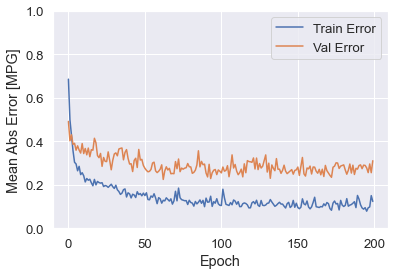

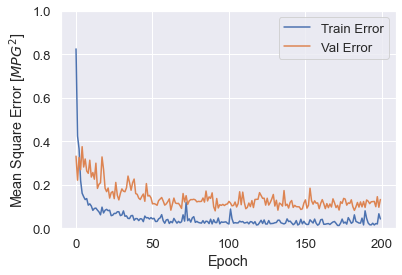

In [82]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
             label='Val Error')
    plt.ylim([0,1])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
             label='Val Error')
    plt.ylim([0,1])
    plt.legend()
    plt.show()

plot_history(history)

In [83]:
loss, mae, mse = model.evaluate(train_data, train_labels)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

108/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [85]:
#'item_level', 'item_class' 'damage_dealt', 'original_xp', 'original_credits', 'kills_made', 'damage_assisted_stun', 'he_hits', 'crew_size', 'hits', 'booster_bonus_credits'

tank_params = [[8, 2, 994.758446, 1051.125426, 41486.045662, 0.614389, 0.0, 0.054945, 4.0, 5.207303, 2978.862081, 5]]

x = gold_scaler.transform(tank_params)[:,:11]
test_predictions = model.predict(x)
xx = np.concatenate((x[0], test_predictions[0]))
gold_scaler.inverse_transform(xx)[-1]

12408.199552116275

In [63]:
res_data[res_data['vehicle_type_cd'] == 9217][features]

,item_level,item_class,damage_dealt,original_xp,original_credits,kills_made,damage_assisted_stun,he_hits,crew_size,hits,booster_bonus_credits
135,8.0,2,994.758446,1051.125426,41486.045662,0.614389,0.0,0.054945,4.0,5.207303,2978.862081
